# Pràctica 1

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sn

import igraph

from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import pycountry

## Preparació del dataset

### Importació de CSVs

In [2]:
airports = pd.read_csv('csv/airports.csv', sep=',', header=0, na_values='\\N', true_values=['Y'], false_values=['"N"'], quotechar='"', encoding="utf-8")
airports

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7693,14106,Rogachyovo Air Base,Belaya,Russia,NaN,ULDA,71.616699,52.478298,272,NaN,NaN,NaN,airport,OurAirports
7694,14107,Ulan-Ude East Airport,Ulan Ude,Russia,NaN,XIUW,51.849998,107.737999,1670,NaN,NaN,NaN,airport,OurAirports
7695,14108,Krechevitsy Air Base,Novgorod,Russia,NaN,ULLK,58.625000,31.385000,85,NaN,NaN,NaN,airport,OurAirports
7696,14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT,-27.261200,-70.779198,670,NaN,NaN,NaN,airport,OurAirports


In [3]:
airlines = pd.read_csv('csv/airlines.csv', sep=',',header=0, na_values='\\N', true_values=['Y'], false_values=['N'], quotechar='"', encoding="utf-8")
airlines.Active = airlines.Active.transform(lambda x: True if x == 'Y' else False)
airlines

,Id,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,NaN,-,NaN,NaN,NaN,True
1,1,Private flight,NaN,-,NaN,NaN,NaN,True
2,2,135 Airways,NaN,NaN,GNL,GENERAL,United States,False
3,3,1Time Airline,NaN,1T,RNX,NEXTIME,South Africa,True
4,4,2 Sqn No 1 Elementary Flying Training School,NaN,NaN,WYT,NaN,United Kingdom,False
...,...,...,...,...,...,...,...,...
6157,21248,GX Airlines,NaN,NaN,CBG,SPRAY,China,True
6158,21251,Lynx Aviation (L3/SSX),NaN,NaN,SSX,Shasta,United States,False
6159,21268,Jetgo Australia,NaN,JG,NaN,NaN,Australia,True
6160,21270,Air Carnival,NaN,2S,NaN,NaN,India,True


In [4]:
routes = pd.read_csv('csv/routes.csv', sep=',', header=0, na_values='\\N', true_values=['Y'], false_values=['"N"'], quotechar='"', encoding="utf-8")
routes = routes.fillna(-1)
routes = routes[routes.Airline_ID != float('nan')]
routes = routes[routes.Src_A_ID != float('nan')]
routes = routes[routes.Dst_A_ID != float('nan')]
routes.Airline_ID = routes.Airline_ID.astype(int)
routes.Src_A_ID = routes.Src_A_ID.astype(int)
routes.Dst_A_ID = routes.Dst_A_ID.astype(int)
routes

,Airline,Airline_ID,Src_A,Src_A_ID,Dst_A,Dst_A_ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,-1,0,CR2
1,2B,410,ASF,2966,KZN,2990,-1,0,CR2
2,2B,410,ASF,2966,MRV,2962,-1,0,CR2
3,2B,410,CEK,2968,KZN,2990,-1,0,CR2
4,2B,410,CEK,2968,OVB,4078,-1,0,CR2
...,...,...,...,...,...,...,...,...,...
67658,ZL,4178,WYA,6334,ADL,3341,-1,0,SF3
67659,ZM,19016,DME,4029,FRU,2912,-1,0,734
67660,ZM,19016,FRU,2912,DME,4029,-1,0,734
67661,ZM,19016,FRU,2912,OSS,2913,-1,0,734


In [5]:
# countries = pd.read_csv('csv/countries.csv', sep=',', header=0, na_values='\\N', true_values=['Y'], false_values=['"N"'], quotechar='"', encoding="latin-1")
# countries

### Fusió de taules

In [6]:
# Source Airport info
routes_ext = pd.merge(routes, airports, left_on='Src_A_ID',right_on='Id')
routes_ext = routes_ext.rename(columns={"Name": "Src_Name", "Country": "Src_Country"})

# Destination Airport info
routes_ext = pd.merge(routes_ext, airports, left_on='Dst_A_ID', right_on='Id')
routes_ext = routes_ext.rename(columns={"Name": "Dst_Name", "Country": "Dst_Country"})

# Airline info
routes_ext = pd.merge(routes_ext, airlines, left_on='Airline_ID', right_on='Id')
routes_ext = routes_ext.rename(columns={"Name": "Airline_Name", "Country": "Airline_Country"})

routes_ext.columns

Index(['Airline', 'Airline_ID', 'Src_A', 'Src_A_ID', 'Dst_A', 'Dst_A_ID',
       'Codeshare', 'Stops', 'Equipment', 'Id_x', 'Src_Name', 'City_x',
       'Src_Country', 'IATA_x', 'ICAO_x', 'Latitude_x', 'Longitude_x',
       'Altitude_x', 'Timezone_x', 'DST_x', 'Tz database time zone_x',
       'Type_x', 'Source_x', 'Id_y', 'Dst_Name', 'City_y', 'Dst_Country',
       'IATA_y', 'ICAO_y', 'Latitude_y', 'Longitude_y', 'Altitude_y',
       'Timezone_y', 'DST_y', 'Tz database time zone_y', 'Type_y', 'Source_y',
       'Id', 'Airline_Name', 'Alias', 'IATA', 'ICAO', 'Callsign',
       'Airline_Country', 'Active'],
      dtype='object')

## Graf

In [7]:
# Construeix el graf segons un dataframe passat
# es pot elegir eliminar EUA i Canadà, o elegir un sol país o aerolínia
def build_graph(dfs, plot=None, verbose=True, seed = 1234, name = 'graf', p_color = 'color_pais', p_label = 'name', rem_can_eua = False, id_airline = None, pais=None):

    g = igraph.Graph()

    for i, row in dfs.iterrows():
        
        if (pais == None or (row.Src_Country == pais and row.Dst_Country == pais))\
            and (id_airline == None or row.Airline_ID == id_airline)\
            and (not rem_can_eua or (row.Src_Country != 'Canada' and row.Dst_Country != 'Canada' and row.Src_Country != 'United States' and row.Dst_Country != 'United States')):
        
            if 'name' not in g.vs.attribute_names():
                g.add_vertex(
                    name=str(row.Src_A_ID), 
                    pais=row.Src_Country,
                    continent=dict_pais_continent[row.Src_Country],
                    color_pais = dict_pais_color[row.Src_Country],
                    color_continent = dict_continent_color[dict_pais_continent[row.Src_Country]],
                    ciutat= row.City_x)
                g.add_vertex(
                    name=str(row.Dst_A_ID), 
                    pais=row.Dst_Country,
                    continent=dict_pais_continent[row.Dst_Country],
                    color_pais = dict_pais_color[row.Dst_Country],
                    color_continent = dict_continent_color[dict_pais_continent[row.Dst_Country]],
                    ciutat= row.City_y)
            else:
                if str(row.Src_A_ID) not in g.vs['name']:
                    g.add_vertex(
                        name=str(row.Src_A_ID), 
                        pais=row.Src_Country,
                        continent=dict_pais_continent[row.Src_Country],
                        color_pais = dict_pais_color[row.Src_Country],
                        color_continent = dict_continent_color[dict_pais_continent[row.Src_Country]],
                        ciutat= row.City_x)
                if str(row.Dst_A_ID) not in g.vs['name']:
                    g.add_vertex(
                        name=str(row.Dst_A_ID), 
                        pais=row.Dst_Country,
                        continent=dict_pais_continent[row.Dst_Country],
                        color_pais = dict_pais_color[row.Dst_Country],
                        color_continent = dict_continent_color[dict_pais_continent[row.Dst_Country]],
                        ciutat= row.City_y)

            if not g.are_connected(str(row.Src_A_ID), str(row.Dst_A_ID)):
                g.add_edge(str(row.Src_A_ID), str(row.Dst_A_ID), rutas=[i])
            else:
                g.es['rutas'][g.get_eid(str(row.Src_A_ID), str(row.Dst_A_ID))].append(i)

    if verbose:
        print(g.summary())
    
    plot_graph(g, plot = plot, seed = seed, name = name, p_color = p_color, p_label = p_label)
    
    return g

# dibuixa un graf, amb els paràmetres passats
# es pot elegir pintar-lo al quadern, o guardar-lo com a imatge
def plot_graph(g, plot = None, seed = 1234, name = 'graf', p_color = 'color_pais', p_label = 'name', p_size = None, layout = None, vertex_size=20, margin=20, label_size=8):
        
    visual_style = {}
    
    if plot == 'show':
        
        g.vs['label'] = None
        
        if p_color != None:
            g.vs['color'] = g.vs[p_color]
        else:
            g.vs['color'] = None
        
        return igraph.plot(g, bbox=(600, 600), vertex_size=10, layout=g.layout_drl() if layout == None else layout)
        
    elif plot == 'save':
        
        # etiquetes
        if p_label != None:
            g.vs['label'] = g.vs[p_label]
        else:
            g.vs['label'] = None
        
        # colors
        if p_color != None:
            g.vs['color'] = g.vs[p_color]
        else:
            g.vs['color'] = None
        
        # tamanys
        if p_size != None:
            g.vs['size'] = g.vs[p_size]
        else:
            g.vs['size'] = None
            visual_style["vertex_size"] = vertex_size
        
        random.seed(seed)
        visual_style["bbox"] = (10000,10000)
        visual_style["margin"] = margin
        visual_style["vertex_label_size"] = label_size
        visual_style["edge_curved"] = False
        my_layout = g.layout_drl() if layout == None else layout
        visual_style["layout"] = my_layout
        
        out = igraph.plot(g, **visual_style)
        out.save(name + '.png')

# torna la informació sobre la llista de rutes entre dos aeroports
def info_rutas_arista(t_rutas, g, id_arista, columna = None):
    if columna:
        return t_rutas.loc[g.es['rutas'][id_arista]][columna]
    else:
        return t_rutas.loc[g.es['rutas'][id_arista]]

# torna la informació sobre l'aeroport d'un node
def info_aeropuerto_vertice(t_aeropuertos, g, idv):
        
    if isinstance(idv, list):
        if isinstance(idv[0], str):
            return t_aeropuertos.loc[t_aeropuertos['Id'].isin(list(map(int, idv)))]
        else:
            return t_aeropuertos.loc[t_aeropuertos['Id'].isin(list(map(int, np.array(g.vs['name'])[np.isin(np.array(g.vs.indices), np.array(idv))])))]
    else:
        if isinstance(idv, str):
            return t_aeropuertos.loc[t_aeropuertos['Id'] == int(idv)]
        else:
            return t_aeropuertos.loc[t_aeropuertos['Id'] == int(g.vs['name'][idv])]

In [8]:
# Països diferents
paisos = list(routes_ext['Src_Country'])
paisos.extend(list(routes_ext['Dst_Country']))
paisos = list(set(paisos))

# Color per cada país
colors_pais = ["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])for j in range(len(paisos))]
dict_pais_color = dict(zip(paisos, colors_pais))

# Continent per cada país
alpha2 = [country_name_to_country_alpha2(pais) for pais in paisos]

rem = ['TL', 'SX', 'EH']
rep = ['CN', 'US', 'MA']

for i in range(len(rem)):
    ind = alpha2.index(rem[i])
    alpha2[ind] = rep[i]

continents_tots = [country_alpha2_to_continent_code(a2) for a2 in alpha2]
dict_pais_continent = dict(zip(paisos, continents_tots))

# Continents diferents
continents = list(set(continents_tots))
colors_continent = ["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])for j in range(len(continents))]
dict_continent_color = dict(zip(continents, colors_continent))

### Mostra d'aeroports (o tots ells)

In [9]:
all_airports = set({})
all_airports.update(routes.Src_A_ID)
all_airports.update(routes.Dst_A_ID)
all_airports = list(all_airports)

r_airports = random.sample(all_airports, len(all_airports))

dfs = routes_ext[routes_ext.Src_A_ID.isin(r_airports)]
dfs = dfs[dfs.Dst_A_ID.isin(r_airports)]

### Construcció del graf

In [10]:
g = build_graph(dfs)

IGRAPH UN-- 3214 18859 -- 
+ attr: ciutat (v), color_continent (v), color_pais (v), continent (v), name (v), pais (v), rutas (e)


### Visualizació

In [11]:
plot_graph(g, plot='save', p_color = 'color_pais', name = 'graf_paisos')
plot_graph(g, plot='save', p_color = 'color_continent', name = 'graf_continents')

## Càlcul de mètriques

### MIDA

In [12]:
print('n =', len(g.vs))
print('m =', len(g.es))
print('c =', round(igraph.mean(g.degree()),2))
print('densidad =', round(g.density(), 5))
print('diámetro =', g.diameter())
print('l (longitud del camino medio) =', round(g.average_path_length(),2))

n = 3214
m = 18859
c = 11.74
densidad = 0.00365
diámetro = 12
l (longitud del camino medio) = 3.96


#### Rutes més llargues

In [13]:
distances = g.shortest_paths()
da = np.array(distances).flatten()
sort = np.sort(da[da != float('inf')])[::-1]

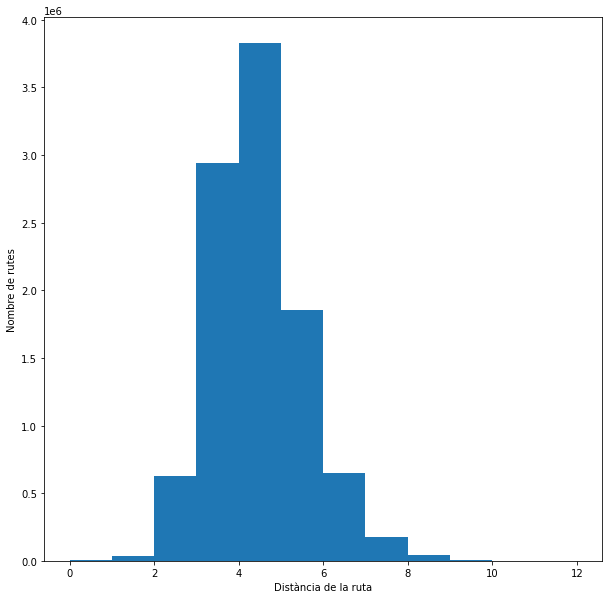

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.hist(sort, bins = 12)
plt.xlabel('Distància de la ruta')
plt.ylabel('Nombre de rutes')
plt.show()

Esborrant Canadà i EUA:

In [15]:
build_graph(dfs, plot = 'save', name = 'graf_sense_canada_eua', rem_can_eua = True)

IGRAPH UN-- 2452 14378 -- 
+ attr: ciutat (v), color_continent (v), color_pais (v), continent (v), name (v), pais (v), rutas (e)


### COMPONENTS

In [16]:
comps = sorted(g.clusters(), key=len, reverse=True)
print('nº components =', len(g.clusters()))
print('Mida de les components =', [len(i) for i in comps])
print('S =', round(len(comps[0]))/len(g.vs), 5)

nº components = 7
Mida de les components = [3188, 10, 4, 4, 4, 2, 2]
S = 0.9919103920348475 5


Llista d'aeroports de cada component:

In [17]:
info_aeropuerto_vertice(airports, g, comps[1])

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
1928,1998,Koné Airport,Kone,New Caledonia,KNQ,NWWD,-21.054300,164.837006,23,11.0,U,Pacific/Noumea,airport,OurAirports
1929,1999,Koumac Airport,Koumac,New Caledonia,KOC,NWWK,-20.546301,164.255997,42,11.0,U,Pacific/Noumea,airport,OurAirports
1930,2000,Lifou Airport,Lifou,New Caledonia,LIF,NWWL,-20.774799,167.240005,92,11.0,U,Pacific/Noumea,airport,OurAirports
1931,2001,Nouméa Magenta Airport,Noumea,New Caledonia,GEA,NWWM,-22.258301,166.473007,10,11.0,U,Pacific/Noumea,airport,OurAirports
1932,2002,Maré Airport,Mare,New Caledonia,MEE,NWWR,-21.481701,168.037994,141,11.0,U,Pacific/Noumea,airport,OurAirports
1933,2003,Touho Airport,Touho,New Caledonia,TOU,NWWU,-20.790001,165.259003,10,11.0,U,Pacific/Noumea,airport,OurAirports
1934,2004,Ouvéa Airport,Ouvea,New Caledonia,UVE,NWWV,-20.640600,166.572998,23,11.0,U,Pacific/Noumea,airport,OurAirports
4586,5919,Tiga Airport,Tiga,New Caledonia,TGJ,NWWA,-21.096100,167.804001,128,11.0,U,Pacific/Noumea,airport,OurAirports
4587,5920,Île Art - Waala Airport,Waala,New Caledonia,BMY,NWWC,-19.720600,163.660995,306,11.0,U,Pacific/Noumea,airport,OurAirports
4588,5921,Île des Pins Airport,Île des Pins,New Caledonia,ILP,NWWE,-22.588900,167.455994,315,11.0,U,Pacific/Noumea,airport,OurAirports


In [18]:
info_aeropuerto_vertice(airports, g, comps[2])

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
4344,5642,Ondangwa Airport,Ondangwa,Namibia,OND,FYOA,-17.878201,15.952600,3599,1.0,S,Africa/Windhoek,airport,OurAirports
4347,5645,Eros Airport,Windhoek,Namibia,ERS,FYWE,-22.612200,17.080400,5575,1.0,S,Africa/Windhoek,airport,OurAirports
5162,6779,Katima Mulilo Airport,Mpacha,Namibia,MPA,FYKM,-17.634399,24.176701,3144,1.0,S,Africa/Windhoek,airport,OurAirports
5719,7634,Rundu Airport,Rundu,Namibia,NDU,FYRU,-17.956499,19.719400,3627,1.0,S,Africa/Windhoek,airport,OurAirports


In [19]:
info_aeropuerto_vertice(airports, g, comps[3])

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
3660,3860,Unalaska Airport,Unalaska,United States,DUT,PADU,53.900101,-166.544006,22,-9.0,A,America/Anchorage,airport,OurAirports
4769,6134,Akutan Seaplane Base,Akutan,United States,KQA,KQA,54.133770,-165.778896,0,-9.0,A,America/Anchorage,airport,OurAirports
5431,7195,Atka Airport,Atka,United States,AKB,PAAK,52.220299,-174.205994,57,-10.0,A,America/Adak,airport,OurAirports
5432,7196,Nikolski Air Station,Nikolski,United States,IKO,PAKO,52.941601,-168.848999,77,-9.0,A,America/Anchorage,airport,OurAirports


In [20]:
info_aeropuerto_vertice(airports, g, comps[4])

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
3526,3726,Boeing Field King County International Airport,Seattle,United States,BFI,KBFI,47.529999,-122.302002,21,-8.0,A,America/Los_Angeles,airport,OurAirports
4423,5731,William R Fairchild International Airport,Port Angeles,United States,CLM,KCLM,48.120201,-123.500000,291,-8.0,A,America/Los_Angeles,airport,OurAirports
5363,7082,Friday Harbor Airport,Friday Harbor,United States,FRD,KFHR,48.521999,-123.024002,113,-8.0,A,America/Los_Angeles,airport,OurAirports
5364,7083,Orcas Island Airport,Eastsound,United States,ESD,KORS,48.708199,-122.910004,31,-8.0,A,America/Los_Angeles,airport,OurAirports


In [21]:
info_aeropuerto_vertice(airports, g, comps[5])

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
4151,5439,Neerlerit Inaat Airport,Neerlerit Inaat,Greenland,CNP,BGCO,70.743103,-22.650499,45,-1.0,E,America/Scoresbysund,airport,OurAirports
6008,8208,Ittoqqortoormiit Heliport,Ittoqqortoormiit,Greenland,OBY,BGSC,70.488229,-21.971680,238,-1.0,U,America/Scoresbysund,airport,OurAirports


In [22]:
info_aeropuerto_vertice(airports, g, comps[6])

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
3883,4106,Victoria Harbour Seaplane Base,Victoria,Canada,YWH,CYWH,48.424986,-123.388867,0,-8.0,A,America/Vancouver,airport,OurAirports
4206,5500,Vancouver Harbour Water Aerodrome,Vancouver,Canada,CXH,CYHC,49.294399,-123.111000,0,-8.0,A,America/Vancouver,airport,OurAirports


### ÍNDEXS DE CENTRALITAT

#### Eigenvector

In [23]:
eigenvector = g.eigenvector_centrality(scale=False)
top10 = sorted(list(enumerate(eigenvector)), key=lambda tup: tup[1])[:-11:-1]
for i in range(len(top10)):
    top10[i] = (g.vs['name'][top10[i][0]], top10[i][1])
top10

[('580', 0.16794377981936828),
 ('340', 0.16643896922862925),
 ('1382', 0.15950133958714677),
 ('346', 0.14860374658916267),
 ('1555', 0.13639190550766245),
 ('507', 0.13595620151701884),
 ('1701', 0.12921114373206502),
 ('1218', 0.1282291706343795),
 ('1678', 0.12606270935307948),
 ('1229', 0.12304355424842235)]

In [24]:
top10_ids = [tup[0] for tup in top10]
info_aeropuerto_vertice(airports, g, top10_ids)

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
336,340,Frankfurt am Main Airport,Frankfurt,Germany,FRA,EDDF,50.033333,8.570556,364,1.0,E,Europe/Berlin,airport,OurAirports
342,346,Munich Airport,Munich,Germany,MUC,EDDM,48.353802,11.786100,1487,1.0,E,Europe/Berlin,airport,OurAirports
502,507,London Heathrow Airport,London,United Kingdom,LHR,EGLL,51.470600,-0.461941,83,0.0,E,Europe/London,airport,OurAirports
574,580,Amsterdam Airport Schiphol,Amsterdam,Netherlands,AMS,EHAM,52.308601,4.763890,-11,1.0,E,Europe/Amsterdam,airport,OurAirports
1186,1218,Barcelona International Airport,Barcelona,Spain,BCN,LEBL,41.297100,2.078460,12,1.0,E,Europe/Madrid,airport,OurAirports
1196,1229,Adolfo Suárez Madrid–Barajas Airport,Madrid,Spain,MAD,LEMD,40.471926,-3.562640,1998,1.0,E,Europe/Madrid,airport,OurAirports
1346,1382,Charles de Gaulle International Airport,Paris,France,CDG,LFPG,49.012798,2.550000,392,1.0,E,Europe/Paris,airport,OurAirports
1514,1555,Leonardo da Vinci–Fiumicino Airport,Rome,Italy,FCO,LIRF,41.800278,12.238889,13,1.0,E,Europe/Rome,airport,OurAirports
1633,1678,Zürich Airport,Zurich,Switzerland,ZRH,LSZH,47.464699,8.549170,1416,1.0,E,Europe/Zurich,airport,OurAirports
1655,1701,Atatürk International Airport,Istanbul,Turkey,ISL,LTBA,40.976898,28.814600,163,3.0,E,Europe/Istanbul,airport,OurAirports


#### Pagerank

In [25]:
pagerank = g.pagerank()
top10 = sorted(list(enumerate(pagerank)), key=lambda tup: tup[1])[:-11:-1]
for i in range(len(top10)):
    top10[i] = (g.vs['name'][top10[i][0]], top10[i][1])
top10

[('3682', 0.004825883012347098),
 ('3830', 0.004496999734166477),
 ('1701', 0.004482661649597815),
 ('3670', 0.004429577419402283),
 ('3751', 0.004387802927050466),
 ('1382', 0.004171008337545805),
 ('4029', 0.00413734160891971),
 ('580', 0.004105507355434262),
 ('340', 0.004046319438946684),
 ('3364', 0.003929902916080612)]

In [26]:
top10_ids = [tup[0] for tup in top10]
info_aeropuerto_vertice(airports, g, top10_ids)

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
336,340,Frankfurt am Main Airport,Frankfurt,Germany,FRA,EDDF,50.033333,8.570556,364,1.0,E,Europe/Berlin,airport,OurAirports
574,580,Amsterdam Airport Schiphol,Amsterdam,Netherlands,AMS,EHAM,52.308601,4.763890,-11,1.0,E,Europe/Amsterdam,airport,OurAirports
1346,1382,Charles de Gaulle International Airport,Paris,France,CDG,LFPG,49.012798,2.550000,392,1.0,E,Europe/Paris,airport,OurAirports
1655,1701,Atatürk International Airport,Istanbul,Turkey,ISL,LTBA,40.976898,28.814600,163,3.0,E,Europe/Istanbul,airport,OurAirports
3170,3364,Beijing Capital International Airport,Beijing,China,PEK,ZBAA,40.080101,116.584999,116,8.0,U,Asia/Shanghai,airport,OurAirports
3470,3670,Dallas Fort Worth International Airport,Dallas-Fort Worth,United States,DFW,KDFW,32.896801,-97.038002,607,-6.0,A,America/Chicago,airport,OurAirports
3482,3682,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,1026,-5.0,A,America/New_York,airport,OurAirports
3551,3751,Denver International Airport,Denver,United States,DEN,KDEN,39.861698,-104.672997,5431,-7.0,A,America/Denver,airport,OurAirports
3630,3830,Chicago O'Hare International Airport,Chicago,United States,ORD,KORD,41.978600,-87.904800,672,-6.0,A,America/Chicago,airport,OurAirports
3815,4029,Domodedovo International Airport,Moscow,Russia,DME,UUDD,55.408798,37.906300,588,3.0,N,Europe/Moscow,airport,OurAirports


#### Closeness

Usada funció de NetworkX perquè no s'han sabut interpretar els resultats de la de igraph:

In [27]:
import networkx as nx
G = nx.Graph(g.get_edgelist())

In [28]:
cl = nx.closeness_centrality(G)

In [29]:
closeness = list(cl.values()) # g.closeness(normalized=True) 
top10 = sorted(list(enumerate(closeness)), key=lambda tup: tup[1])[:-11:-1]
for i in range(len(top10)):
    top10[i] = (g.vs['name'][top10[i][0]], top10[i][1])
top10

[('340', 0.4109203685518288),
 ('1382', 0.40831960672555134),
 ('507', 0.4057515588845102),
 ('580', 0.40188283692718263),
 ('2188', 0.40040663651288394),
 ('3484', 0.39475654286578654),
 ('3797', 0.3942642049475204),
 ('193', 0.38959950644185587),
 ('1701', 0.3884505278040328),
 ('346', 0.38711858869326704)]

In [30]:
top10_ids = [tup[0] for tup in top10]
info_aeropuerto_vertice(airports, g, top10_ids)

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
191,193,Lester B. Pearson International Airport,Toronto,Canada,YYZ,CYYZ,43.677200,-79.630600,569,-5.0,A,America/Toronto,airport,OurAirports
336,340,Frankfurt am Main Airport,Frankfurt,Germany,FRA,EDDF,50.033333,8.570556,364,1.0,E,Europe/Berlin,airport,OurAirports
342,346,Munich Airport,Munich,Germany,MUC,EDDM,48.353802,11.786100,1487,1.0,E,Europe/Berlin,airport,OurAirports
502,507,London Heathrow Airport,London,United Kingdom,LHR,EGLL,51.470600,-0.461941,83,0.0,E,Europe/London,airport,OurAirports
574,580,Amsterdam Airport Schiphol,Amsterdam,Netherlands,AMS,EHAM,52.308601,4.763890,-11,1.0,E,Europe/Amsterdam,airport,OurAirports
1346,1382,Charles de Gaulle International Airport,Paris,France,CDG,LFPG,49.012798,2.550000,392,1.0,E,Europe/Paris,airport,OurAirports
1655,1701,Atatürk International Airport,Istanbul,Turkey,ISL,LTBA,40.976898,28.814600,163,3.0,E,Europe/Istanbul,airport,OurAirports
2100,2188,Dubai International Airport,Dubai,United Arab Emirates,DXB,OMDB,25.252800,55.364399,62,4.0,U,Asia/Dubai,airport,OurAirports
3285,3484,Los Angeles International Airport,Los Angeles,United States,LAX,KLAX,33.942501,-118.407997,125,-8.0,A,America/Los_Angeles,airport,OurAirports
3597,3797,John F Kennedy International Airport,New York,United States,JFK,KJFK,40.639801,-73.778900,13,-5.0,A,America/New_York,airport,OurAirports


#### Betweenness

In [31]:
betweenness = g.betweenness()
top10 = sorted(list(enumerate(betweenness)), key=lambda tup: tup[1])[:-11:-1]
for i in range(len(top10)):
    top10[i] = (g.vs['name'][top10[i][0]], top10[i][1])
top10

[('1382', 327988.10917691817),
 ('3484', 312198.1080670245),
 ('3774', 301486.4351182183),
 ('2188', 285897.28954097896),
 ('340', 270552.4070156179),
 ('580', 263489.1115801093),
 ('3364', 256910.51591503594),
 ('3830', 240371.19893043122),
 ('193', 228825.55597963123),
 ('1701', 218931.24591473403)]

In [32]:
top10_ids = [tup[0] for tup in top10]
info_aeropuerto_vertice(airports, g, top10_ids)

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
191,193,Lester B. Pearson International Airport,Toronto,Canada,YYZ,CYYZ,43.677200,-79.630600,569,-5.0,A,America/Toronto,airport,OurAirports
336,340,Frankfurt am Main Airport,Frankfurt,Germany,FRA,EDDF,50.033333,8.570556,364,1.0,E,Europe/Berlin,airport,OurAirports
574,580,Amsterdam Airport Schiphol,Amsterdam,Netherlands,AMS,EHAM,52.308601,4.763890,-11,1.0,E,Europe/Amsterdam,airport,OurAirports
1346,1382,Charles de Gaulle International Airport,Paris,France,CDG,LFPG,49.012798,2.550000,392,1.0,E,Europe/Paris,airport,OurAirports
1655,1701,Atatürk International Airport,Istanbul,Turkey,ISL,LTBA,40.976898,28.814600,163,3.0,E,Europe/Istanbul,airport,OurAirports
2100,2188,Dubai International Airport,Dubai,United Arab Emirates,DXB,OMDB,25.252800,55.364399,62,4.0,U,Asia/Dubai,airport,OurAirports
3170,3364,Beijing Capital International Airport,Beijing,China,PEK,ZBAA,40.080101,116.584999,116,8.0,U,Asia/Shanghai,airport,OurAirports
3285,3484,Los Angeles International Airport,Los Angeles,United States,LAX,KLAX,33.942501,-118.407997,125,-8.0,A,America/Los_Angeles,airport,OurAirports
3574,3774,Ted Stevens Anchorage International Airport,Anchorage,United States,ANC,PANC,61.174400,-149.996002,152,-9.0,A,America/Anchorage,airport,OurAirports
3630,3830,Chicago O'Hare International Airport,Chicago,United States,ORD,KORD,41.978600,-87.904800,672,-6.0,A,America/Chicago,airport,OurAirports


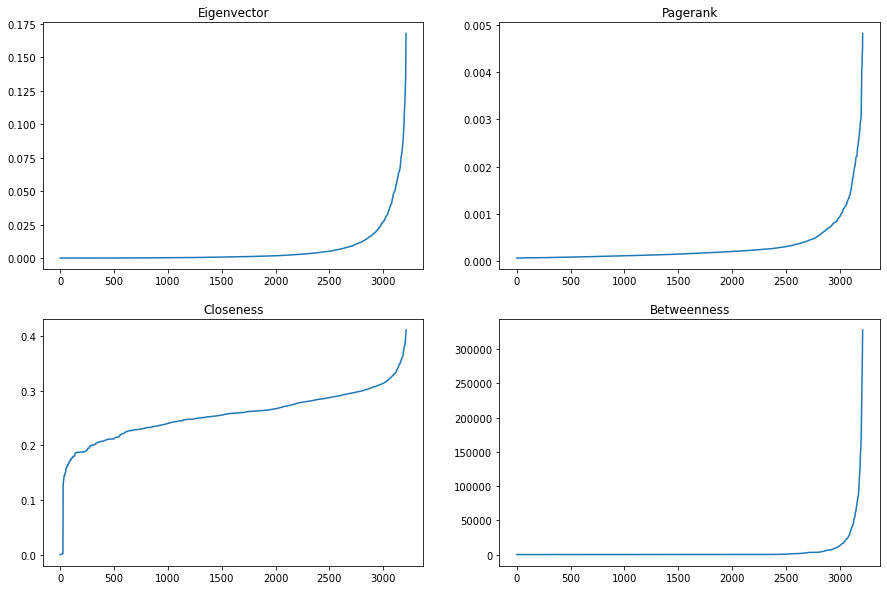

In [33]:
plt.rcParams['figure.figsize'] = [15, 10]
f, ax = plt.subplots(2,2)
ax = ax.flatten()
i = 0

ax[i].plot(sorted(eigenvector))
ax[i].title.set_text('Eigenvector')
i += 1

ax[i].plot(sorted(pagerank))
ax[i].title.set_text('Pagerank')
i += 1

ax[i].plot(sorted(closeness))
ax[i].title.set_text('Closeness')
i += 1

ax[i].plot(sorted(betweenness))
ax[i].title.set_text('Betweenness')

#### Clustering

In [34]:
print('clustering =', round(g.transitivity_undirected(),5))

clustering = 0.24972


##### Comparativa d'índexs

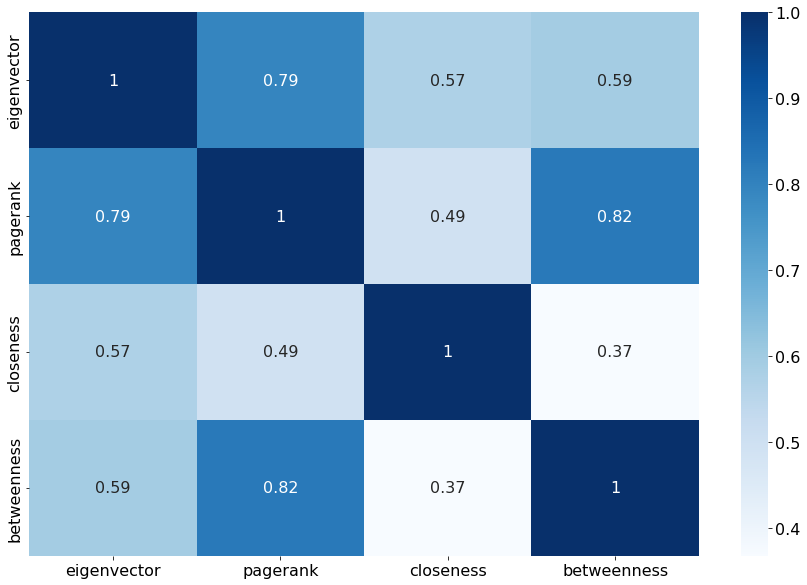

In [35]:
centrality = pd.DataFrame(list(zip(eigenvector, pagerank, closeness, betweenness)), columns =['eigenvector', 'pagerank', 'closeness', 'betweenness'])

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 16

corrMatrix = centrality.corr()
sn.heatmap(corrMatrix, annot=True, cmap="Blues")
plt.show()

#### Homofília

In [36]:
# g.assortativity_nominal(g.vs.indices, g.vs['color'])
g.assortativity_degree(g.vs.indices)

-0.016633481283398168

## APROXIMACIÓ A POWER LAW

Càlcul dels graus, el seu histograma i la distribució de probabilitat:

In [37]:
graus = g.degree()
hist, bins = np.histogram(graus, bins=max(graus))
p_g = hist / len(g.vs)

Càlcul de l'aproximació a power-law:

In [38]:
plf = igraph.power_law_fit(graus, xmin=1)
print(plf)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.000000
Cutoff (xmin)     = 1.000000

Log-likelihood    = -10818.409006

H0: data was drawn from the fitted distribution

KS test statistic = 0.384529
p-value           = 0.000000

H0 rejected at significance level 0.05


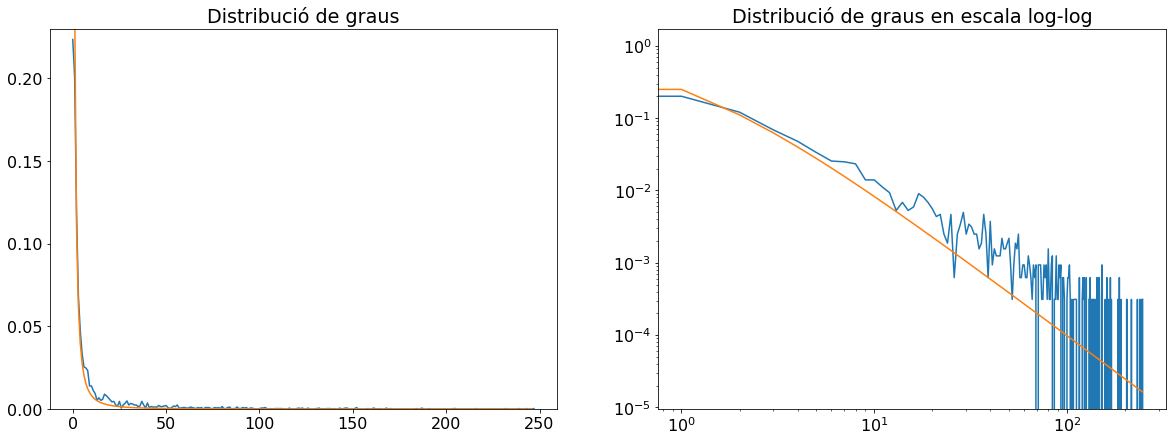

In [39]:
graus = g.degree()
hist, bins = np.histogram(graus, bins=max(graus))
p_g = hist / len(g.vs)

plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams['font.size'] = 16
f, axarr = plt.subplots(1,2)

axarr[0].title.set_text('Distribució de graus')
axarr[0].plot(p_g)
axarr[0].plot((np.array(range(1,max(graus)))**-plf.alpha)*(plf.xmin))
axarr[0].set_ylim([0.0, 0.23])

axarr[1].title.set_text('Distribució de graus en escala log-log')
axarr[1].loglog(p_g)
axarr[1].loglog((np.array(range(1,max(graus)))**-plf.alpha)*(plf.xmin))
plt.show()


## Casos concrets d'estudi

### Ruta més llarga del graf: el cas de Canadà

Càlcul d'una de les rutes més llargues del graf:

In [40]:
maximum = 0
max_index_src = 0
max_index_dst = 0
for i, src in enumerate(distances):
    arr = np.array(src)
    max_value = np.max(arr[arr != float('inf')])
    
    if max_value > maximum:
        max_index_dst = src.index(max_value)
        max_index_src = i
        maximum = max_value

shortest_path = g.get_shortest_paths(v=max_index_src, to=max_index_dst)[0]
shortest_path_ids = [g.vs['name'][i] for i in shortest_path]
shortest_path_edges = [(shortest_path_ids[i], shortest_path_ids[i+1]) for i in range(len(shortest_path_ids)-1)]
print(shortest_path_ids)
info_aeropuerto_vertice(airports, g, shortest_path)

['5535', '5504', '5506', '6727', '62', '146', '193', '143', '91', '5490', '5543', '5482', '5522']


,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
61,62,La Grande Rivière Airport,La Grande Riviere,Canada,YGL,CYGL,53.625301,-77.704201,639,-5.0,A,America/Toronto,airport,OurAirports
90,91,Moosonee Airport,Moosonee,Canada,YMO,CYMO,51.291100,-80.607803,30,-5.0,A,America/Toronto,airport,OurAirports
141,143,Timmins/Victor M. Power,Timmins,Canada,YTS,CYTS,48.569698,-81.376701,967,-5.0,A,America/Toronto,airport,OurAirports
144,146,Montreal / Pierre Elliott Trudeau Internationa...,Montreal,Canada,YUL,CYUL,45.470600,-73.740799,118,-5.0,A,America/Toronto,airport,OurAirports
191,193,Lester B. Pearson International Airport,Toronto,Canada,YYZ,CYYZ,43.677200,-79.630600,569,-5.0,A,America/Toronto,airport,OurAirports
4188,5482,Attawapiskat Airport,Attawapiskat,Canada,YAT,CYAT,52.927502,-82.431900,31,-5.0,A,America/Toronto,airport,OurAirports
4196,5490,Fort Albany Airport,Fort Albany,Canada,YFA,CYFA,52.201401,-81.696899,48,-5.0,A,America/Toronto,airport,OurAirports
4210,5504,Ivujivik Airport,Ivujivik,Canada,YIK,CYIK,62.417301,-77.925301,126,-5.0,A,America/Toronto,airport,OurAirports
4212,5506,Akulivik Airport,Akulivik,Canada,AKV,CYKO,60.818600,-78.148598,75,-5.0,A,America/Toronto,airport,OurAirports
4228,5522,Peawanuck Airport,Peawanuck,Canada,YPO,CYPO,54.988098,-85.443298,173,-5.0,A,America/Toronto,airport,OurAirports


Càlcul del graf i visualització:

IGRAPH UN-- 205 430 -- 
+ attr: color (v), name (v), color (e), rutas (e)


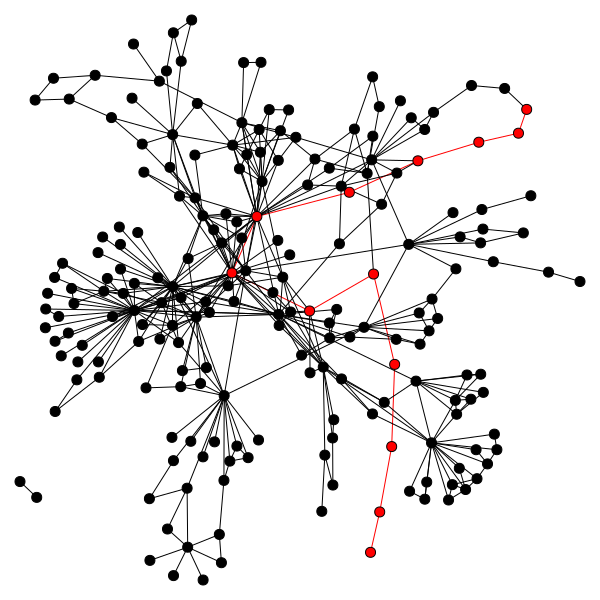

In [41]:
# GRAF AMB ARESTES DE RUTA MÉS LLARGA EN VERMELL
g = igraph.Graph()

for i, row in dfs.iterrows():
    if row.Src_Country == 'Canada' and row.Dst_Country == 'Canada':
        if 'name' not in g.vs.attribute_names():
            g.add_vertex(
                name=str(row.Src_A_ID),
                color= 'red' if ((str(row.Src_A_ID), str(row.Dst_A_ID)) in shortest_path_edges) or ((str(row.Dst_A_ID), str(row.Src_A_ID)) in shortest_path_edges) else 'black')
            g.add_vertex(
                name=str(row.Dst_A_ID),
                color= 'red' if ((str(row.Src_A_ID), str(row.Dst_A_ID)) in shortest_path_edges) or ((str(row.Dst_A_ID), str(row.Src_A_ID)) in shortest_path_edges) else 'black')
        else:
            if str(row.Src_A_ID) not in g.vs['name']:
                g.add_vertex(
                    name=str(row.Src_A_ID),
                    color= 'red' if ((str(row.Src_A_ID), str(row.Dst_A_ID)) in shortest_path_edges) or ((str(row.Dst_A_ID), str(row.Src_A_ID)) in shortest_path_edges) else 'black')
            if str(row.Dst_A_ID) not in g.vs['name']:
                g.add_vertex(
                    name=str(row.Dst_A_ID),
                    color= 'red' if ((str(row.Src_A_ID), str(row.Dst_A_ID)) in shortest_path_edges) or ((str(row.Dst_A_ID), str(row.Src_A_ID)) in shortest_path_edges) else 'black')
        if not g.are_connected(str(row.Src_A_ID), str(row.Dst_A_ID)):
            g.add_edge(
                str(row.Src_A_ID), str(row.Dst_A_ID), 
                rutas=[i], 
                color= 'red' if ((str(row.Src_A_ID), str(row.Dst_A_ID)) in shortest_path_edges) or ((str(row.Dst_A_ID), str(row.Src_A_ID)) in shortest_path_edges) else 'black')
        
print(g.summary())

random.seed(12345)
igraph.plot(g, bbox=(600, 600), vertex_size=10)

### Graf d'un país

In [42]:
g_espanya = build_graph(dfs, pais = 'Spain')
g_espanya.vs['graus'] = np.array(g_espanya.degree())*20
plot_graph(g_espanya, plot='save', p_color='color_continent', name='Pais_Spain', p_label='ciutat', p_size='graus', margin=200, label_size=80)

IGRAPH UN-- 40 147 -- 
+ attr: ciutat (v), color_continent (v), color_pais (v), continent (v), name (v), pais (v), rutas (e)


In [43]:
round(g_espanya.average_path_length(),2)

1.99

In [44]:
g_espanya.diameter()

4

### Graf de l'aerolínia amb més aeroports:

Aerolínia 1 (Ryanair):

In [45]:
id_aerolinia = list(dict(pd.value_counts(dfs['Airline_ID'])))[0]

g_aerolinia = build_graph(dfs, id_airline=id_aerolinia)
plot_graph(g_aerolinia, plot='save', p_color='color_continent', name='Aerolinia_Ryanair', vertex_size=100, margin=100, label_size=20)
print()

airlines[airlines['Id'] == id_aerolinia]

IGRAPH UN-- 176 1242 -- 
+ attr: ciutat (v), color_continent (v), color_pais (v), continent (v), name (v), pais (v), rutas (e)



,Id,Name,Alias,IATA,ICAO,Callsign,Country,Active
4290,4296,Ryanair,NaN,FR,RYR,RYANAIR,Ireland,True


Aerolínia 2 (American Airlines):

In [46]:
id_aerolinia = list(dict(pd.value_counts(dfs['Airline_ID'])))[1]

g_aerolinia = build_graph(dfs, id_airline=id_aerolinia)
plot_graph(g_aerolinia, plot='save', p_color='color_continent', name='Aerolinia_AmericanAirlines', vertex_size=100, margin=100, label_size=20)
print()

airlines[airlines['Id'] == id_aerolinia]

IGRAPH UN-- 433 1190 -- 
+ attr: ciutat (v), color_continent (v), color_pais (v), continent (v), name (v), pais (v), rutas (e)



,Id,Name,Alias,IATA,ICAO,Callsign,Country,Active
24,24,American Airlines,NaN,AA,AAL,AMERICAN,United States,True


Aerolínia 2 (United Airlines)

In [47]:
id_aerolinia = list(dict(pd.value_counts(dfs['Airline_ID'])))[2]

g_aerolinia = build_graph(dfs, id_airline=id_aerolinia)
plot_graph(g_aerolinia, plot='save', p_color='color_continent', name='Aerolinia_UnitedAirlines', vertex_size=100, margin=100, label_size=20)
print()

airlines[airlines['Id'] == id_aerolinia]

IGRAPH UN-- 431 1113 -- 
+ attr: ciutat (v), color_continent (v), color_pais (v), continent (v), name (v), pais (v), rutas (e)



,Id,Name,Alias,IATA,ICAO,Callsign,Country,Active
5196,5209,United Airlines,NaN,UA,UAL,UNITED,United States,True


In [48]:
info_aeropuerto_vertice(airports,g,'1198')

,Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
1167,1198,Paphos International Airport,Paphos,Cyprus,PFO,LCPH,34.717999,32.485699,41,2.0,E,Asia/Nicosia,airport,OurAirports
